## P1-1. Environmental Set-up & Data Loading

## 중요한 feature 찾기 위한 기본적인 RF적용

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [ ]:
rawdata=pd.read_csv("P1_dataset.csv",encoding='cp949')
mydata=rawdata.copy()

In [ ]:
mydata.head()

,GOODNO,SUCCYMD,CARNM,CHASNO,CARREGIYMD,YEAR,MISSNM,FUELNM,COLOR,EXHA,TRAVDIST,USEUSENM,OWNECLASNM,INNEEXPOCLASCD_YN,NEWCARPRIC,SUCCPRIC,YEARCHK,BONET,FRONT_LEFT_FENDER,FRONT_RIGHT_FENDER,FRONT_LEFT_DOOR,FRONT_RIGHT_DOOR,BACK_LEFT_DOOR,BACK_RIGHT_DOOR,TRUNK,FRONT_PANNEL,LEFT_STEP,RIGHT_STEP,LEFT_FILER_A,RIGHT_FILER_A,LEFT_FILER_B,RIGHT_FILER_B,LEFT_FILER_C,RIGHT_FILER_C,LEFT_REAR_FENDER,RIGHT_REAR_FENDER,BACK_PANEL1,LEFT_INSIDE_PANEL,RIGHT_INSIDE_PANEL,LEFT_WHEEL_HOUSE,...,LEFT_WHEEL_HOUSE_SHEETING,RIGHT_WHEEL_HOUSE_SHEETING,LEFT_REAR_INSIDE_PANEL_SHEETING,RIGHT_REAR_INSIDE_PANEL_SHEETING,LEFT_REAR_WHEEL_HOUSE_SHEETING,RIGHT_REAR_WHEEL_HOUSE_SHEETING,TRUNK_FLOOR_SHEETING,DASH_PANEL_SHEETING,SHEET_BACK_PANEL_SHEETING,SIDE_MEMBER_FRAME_SHEETING,FLOOR_PANEL_SHEETING,LEFT_SIDE_PANEL_SHEETING,RIGHT_SIDE_PANEL_SHEETING,FLOODING,TOTAL_LOSS,JOINCAR,NOTAVAILABLE,MF_KEY,MJ_MODEL_KEY,DT_MODEL_KEY,MJ_GRADE_KEY,DT_GRADE_KEY,NC_GRADE_KEY,SHIPPING_PRICE,NC_GRADE_PRICE,ABS,AB2,NAVIGATION,VDC,SMARTKEY,SUNLOOPPANORAMA,SUNLOOPCOMMON,SUNLOOPDUAL,DIS,TCS,AB1,ETC,AV,EPS,ECS
0,1512A2469,20160105,모닝 LPi LX 기본 블랙 프리미엄,KNABK518BBT020038,20100616.0,2011,A/T,LPG,C,1000,38480,자가,법인,X,10704916,4300000,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,46,28,158,18054,5192,11310000.0,9490000.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1512A2364,20160105,K3 1.6 가솔린(4도어) Nobless,KNAFZ412BDA040155,20130207.0,2013,A/T,가솔린,A,1600,62240,자가,법인,X,21230000,11650000,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,37,295,1241,21541,13750,NaN,19750000.0,1,1,1,1,1,0,0,0,0,0,0,0,1,0,0
2,1512A2319,20160105,K3 1.6 가솔린(4도어) Trendy,KNAFK412BEA206484,20140128.0,2014,A/T,가솔린,A,1591,37926,자가,법인,X,18043152,12350000,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,37,295,1241,21538,17225,19340000.0,18170000.0,1,1,1,1,1,0,0,0,0,0,0,0,1,0,0
3,1512A1643,20160105,K5 2.0LPI 렌터카 디럭스,KNAGN418BDA366086,20121218.0,2013,A/T,LPG,B,2000,110149,렌트,법인,X,17280000,5900000,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,38,166,5782,20503,10890,17680000.0,17680000.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1512A1371,20160105,K5 2.0LPI 렌터카 스마트,KNAGN415BBA140279,20110428.0,2011,A/T,LPG,D,2000,81675,렌트,법인,X,15800000,4730000,Y,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,2,38,166,5782,20502,5405,15800000.0,15800000.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
mydata.dtypes

GOODNO         object
SUCCYMD         int64
CARNM          object
CHASNO         object
CARREGIYMD    float64
               ...   
AB1             int64
ETC             int64
AV              int64
EPS             int64
ECS             int64
Length: 104, dtype: object

# 새로운 피쳐 추가

만든 파생변수  : 'type_자동차모델명' 

사용한 변수 : 'CARNM

In [ ]:
TypeList = ['K3', 'K5', 'K7', 'K9', '레이', '로체', '리오', '모닝', '비스토', '스팅어', '스펙트라', '쎄라토', '오피러스', '옵티마', '포르테', '프라이드']
Type_name_list=[] #점차 append됨

for Type in TypeList:
  type_name = 'type_' + Type
  Type_name_list.append(type_name)
  mydata[type_name] = mydata.iloc[:,2].str.contains(Type).astype(int)

#모닝 레이디라 레이도 포함한거라 type_레이는 0으로 포함
mydata['type_레이'][(mydata['type_레이']==1)&(mydata['type_모닝']==1)]=0



#나머지 12개 데이터 제거
# mydata['type_나머지']= 0
# (mydata['type_나머지'][ mydata[Type_name_list].sum(axis=1)==0])=1  #나머지에 해당하는 것들 하나의 그룹으로 . 12개나옴

만든 파생변수 : 'using_price'

사용한 변수:'SHIPPING_PRICE' , 'NC_GRADE_PRICE' , 'NEWCARPRIC'

In [ ]:
# https://auto.naver.com/car/lineup.nhn?yearsId=145911 (중고차 시세 링크)

limitprice_per_type={
    'type_K3' :[13700000, 24250000], #K3
'type_K5':[14200000 ,38850000], #K5, K5하이브리드
'type_K7' :[26100000,40320000], #K7, K7하이브리드
'type_K9' :[50900000,92070000], #K9
'type_레이': [11350000,45000000], #레이 ,레이EV 전기차 특수로 4500까지
'type_로체':[15000000,28800000], # 로체
'type_리오':[6000000,19800000], #리오해치백, 리오세단, 리오SF해치백, 리오SR세단
'type_모닝':[6500000,15000000], #모닝
'type_비스토':[5200000,8000000], #비스토
'type_스팅어':[35000000,53000000], # 스팅어
'type_스펙트라':[8500000,14530000],#윙이랑 그냥
'type_쎄라토':[9000000,17290000],#해치백이랑그냥
'type_오피러스':[27700000,55800000],
'type_옵티마':[11990000,24840000], #리갈이랑 그냥
'type_포르테':[13390000,19660000], #해치백 ,쿱
'type_프라이드':[11090000,17480000] #세단이랑 그냥

}

In [ ]:
def apply_limit_price(row):#row 데이터에 적용하는 함수

    for type_ in  Type_name_list:
        if row[Type_name_list][type_] ==1:
            this_type=type_
            break #타입 찾으면 탈출
    #print(type_)
    under=limitprice_per_type[type_][0]
    #print(under)
    upper=limitprice_per_type[type_][1]
    #print(upper)

    for price in  ['SHIPPING_PRICE','NC_GRADE_PRICE','NEWCARPRIC']:
        
        if row[price]==np.NaN:
            continue

        elif row[price]<under:
            continue
        
        elif row[price]>upper:
            continue
        
        else:
            return row[price]
            
    
    return np.NaN #3개 모두 bound값 벗어날때

In [ ]:
mydata['using_price']=mydata.apply(apply_limit_price,axis=1)

In [ ]:
#bound안에 들어가는지 확인코드 (k7의경우 4030만 이하)
mydata['using_price'][mydata['type_K7']==1].max()

40230000.0

만든 파생변수 :'CarAge'

사용한 변수:'SUCCYMD' , 'CARREGIYMD'

In [ ]:
#차 몇년됐는지
mydata['SUCCYMD']=pd.to_datetime(mydata['SUCCYMD'],format='%Y%m%d')
mydata['CARREGIYMD']=pd.to_datetime(mydata['CARREGIYMD'],format='%Y%m%d')
mydata['CarAge']=(mydata['SUCCYMD']-mydata['CARREGIYMD'])

mydata=mydata.dropna(subset=['CarAge']) #1개 nan제거

mydata['CarAge']=mydata['CarAge'].astype(int)  #초단위가 값이 큰데 나중에 정규화됨

만든 파생변수 :'exchange' , 'yongjeob'

사용한 변수:binary변수들 중 교환여부와 판금+용접여부

In [ ]:
#binary합
description=pd.read_excel("/content/drive/Shareddrives/데이터애널리틱스_송재욱교수님_3팀/211012_6주차(해커톤)/P1_Data_Description.xlsx")
exchange=description['컬럼 ID'][17:62]#bonet~side_member_frame2
yongjeob=description['컬럼 ID'][62:77]#LEFT_INSIDE_SHEETING~RIGHT_SIDE_PANEL_SHEETING


mydata['exchange']=mydata[exchange].sum(axis=1) #교환관련 binary합
mydata['yongjeob']=mydata[yongjeob].sum(axis=1) #판금+용접 관련 binary합

used_binary_col=pd.concat([exchange,yongjeob],ignore_index=True).to_list() #나중에 사용한 변수 제거용

만든 파생변수 :'MJ_MODEL_KEY_adj'

사용한 변수:'MJ_MODEL_KEY'

'DT_MODEL_KEY','DT_GRADE_KEY','NC_GRADE_KEY'들은 사용안하고 제거

In [ ]:
def sortedplot(df):
    sorted_df=df.sort_values().reset_index(drop=True)
    sorted_df.plot()

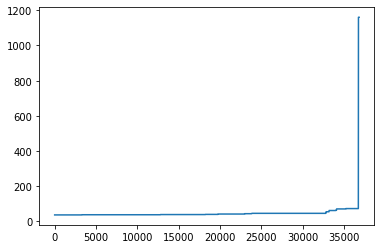

In [ ]:
#찍어보는 용도
sortedplot(mydata['MJ_MODEL_KEY'])

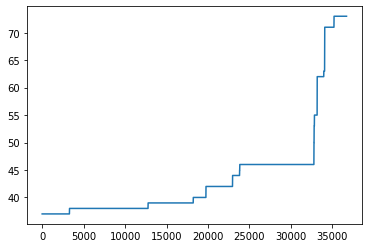

In [ ]:
sortedplot(mydata['MJ_MODEL_KEY'][mydata['MJ_MODEL_KEY']!=1160])

In [ ]:
mj_model_key=mydata['MJ_MODEL_KEY'].sort_values().reset_index(drop=True)
#그룹별 모델적용
for i in [16000,17000,18000,19000,20000]: #보고싶은 index부분 값 적용
    print('index%d에 따른 값:%f'%(i,mj_model_key[i]))


#40까지 하나,46까지하나,55까지하나,64까지 하나, 73까지 하나 , 그리고 1160 따로

def num_to_cat_MJMODELKEY(data):
    if data<=40:
        return 'A'
    elif data<=46:
        return 'B'
    elif data<=55:
        return 'C'
    
    elif data<=64:
        return 'D'
    elif data<=300:
        return 'E'
    else:                #1160을 위한 값
        return 'F'

#만든 mapping함수 적용
mydata['MJ_MODEL_KEY_adj']=mydata['MJ_MODEL_KEY'].apply(num_to_cat_MJMODELKEY)

for i in ['A','B','C','D','E','F']:
    print("%s에서의 평균가격:%d"%(i,mydata['SUCCPRIC'][mydata['MJ_MODEL_KEY_adj']==i].mean()))

index16000에 따른 값:39.000000
index17000에 따른 값:39.000000
index18000에 따른 값:39.000000
index19000에 따른 값:40.000000
index20000에 따른 값:42.000000
A에서의 평균가격:12223450
B에서의 평균가격:4810190
C에서의 평균가격:1606358
D에서의 평균가격:4508046
E에서의 평균가격:4671303
F에서의 평균가격:35465060


만든 파생변수 :'MJ_GRADE_KEY_adj'

사용한 변수:'MJ_GRADE_KEY'

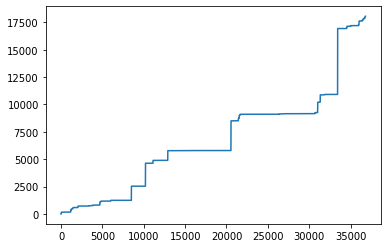

In [ ]:
sortedplot(mydata['MJ_GRADE_KEY'])

In [ ]:
mj_grade_key=mydata['MJ_GRADE_KEY'].sort_values().reset_index(drop=True)
#그룹별 모델적용
for i in [7500,10000,20000,21000,30000,31000,33000,35000]: #보고싶은 index부분 값 적용
    print('index%d에 따른 값:%f'%(i,mj_grade_key[i]))


#1241까지 하나,2534까지하나,5790까지하나,9161까지 하나, 10914까지 하나 , 16930이상

index7500에 따른 값:1241.000000
index10000에 따른 값:2533.000000
index20000에 따른 값:5789.000000
index21000에 따른 값:8502.000000
index30000에 따른 값:9159.000000
index31000에 따른 값:9260.000000
index33000에 따른 값:10912.000000
index35000에 따른 값:17146.000000


In [ ]:
def num_to_cat_MJGRADEKEY(data):
    if data<=1241:
        return 'A'
    elif data<=2534:
        return 'B'
    elif data<=5790:
        return 'C'
    elif data<=9161:
        return 'D'
    elif data<=10914:
        return 'E'
    else:                #16930이상
        return 'F'

In [ ]:
mydata['MJ_GRADE_KEY_adj']=mydata['MJ_GRADE_KEY'].apply(num_to_cat_MJGRADEKEY)
mydata['MJ_GRADE_KEY_adj'].value_counts()

C    10337
D    10125
A     8498
F     3365
E     2767
B     1701
Name: MJ_GRADE_KEY_adj, dtype: int64

In [ ]:
for i in ['A','B','C','D','E','F']:
    print("%s에서의 평균가격:%d"%(i,mydata['SUCCPRIC'][mydata['MJ_GRADE_KEY_adj']==i].mean()))

A에서의 평균가격:8907044
B에서의 평균가격:16710440
C에서의 평균가격:7257536
D에서의 평균가격:5512475
E에서의 평균가격:11400921
F에서의 평균가격:17098234


사용 안할 변수 제거 + 새로운 파생변수에 사용된 데이터들 제거

In [ ]:
#모두다 같은 값 가지는 열
notuselist=[]
for column in mydata.columns:
  if sum(mydata[column] == mydata[column].unique()[0]) == len(mydata):
      notuselist.append(column)

used_binary_col=[x for x in used_binary_col if x not in notuselist] #없어진 것 적용

In [ ]:
#데이터빼기
mydata=mydata.drop(notuselist,axis=1) #모두다 같은 값 가지는 열 빼주는

mydata=mydata.drop(used_binary_col+['CARNM','SHIPPING_PRICE' , 'NC_GRADE_PRICE' , 'NEWCARPRIC','SUCCYMD','CARREGIYMD','MJ_MODEL_KEY','MJ_GRADE_KEY','DT_MODEL_KEY','DT_GRADE_KEY','NC_GRADE_KEY'],axis=1) 
#파생변수 만드는데 사용해서 빼주는
mydata=mydata.drop(['YEAR','GOODNO','CHASNO'],axis=1) #그냥 느낌으로 빼주는



# 이상치 처리 및 결측치 처리

In [ ]:
#남은 null값 확인
mydata.isnull().sum()

MISSNM                  0
FUELNM                  1
COLOR                   0
EXHA                    0
TRAVDIST                0
USEUSENM              323
OWNECLASNM             13
INNEEXPOCLASCD_YN       0
SUCCPRIC                0
YEARCHK                 0
FLOODING                0
TOTAL_LOSS              0
ABS                     0
AB2                     0
NAVIGATION              0
VDC                     0
SMARTKEY                0
SUNLOOPPANORAMA         0
SUNLOOPCOMMON           0
DIS                     0
TCS                     0
AB1                     0
AV                      0
ECS                     0
type_K3                 0
type_K5                 0
type_K7                 0
type_K9                 0
type_레이                 0
type_로체                 0
type_리오                 0
type_모닝                 0
type_비스토                0
type_스팅어                0
type_스펙트라               0
type_쎄라토                0
type_오피러스               0
type_옵티마                0
type_포르테    

In [ ]:
#대부분의 결측치가 using_price인데 우리의 만든 기준을 벗어나는 값이므로 전부 제거,  'USEUSENM'도 300개정도의 결측치 ->중요도 낮으므로 제거
mydata=mydata.dropna()
mydata.isnull().sum().sum()

0

# 원핫인코딩 및 모델 input으로 바꾸는 과정

In [ ]:
mydata.dtypes

MISSNM                object
FUELNM                object
COLOR                 object
EXHA                   int64
TRAVDIST               int64
USEUSENM              object
OWNECLASNM            object
INNEEXPOCLASCD_YN     object
SUCCPRIC               int64
YEARCHK               object
FLOODING               int64
TOTAL_LOSS             int64
ABS                    int64
AB2                    int64
NAVIGATION             int64
VDC                    int64
SMARTKEY               int64
SUNLOOPPANORAMA        int64
SUNLOOPCOMMON          int64
DIS                    int64
TCS                    int64
AB1                    int64
AV                     int64
ECS                    int64
type_K3                int64
type_K5                int64
type_K7                int64
type_K9                int64
type_레이                int64
type_로체                int64
type_리오                int64
type_모닝                int64
type_비스토               int64
type_스팅어               int64
type_스펙트라     

In [ ]:
cat_columns=[i for i,j in zip(mydata.columns,mydata.dtypes) if j=='object']
num_columns=['EXHA','TRAVDIST','using_price','CarAge','exchange','yongjeob','SUCCPRIC'] #예측해야할 y값 포함한
already_oh_columns=[i for i in mydata.columns if i not in cat_columns+num_columns] #binary데이터 

In [ ]:
mydata[cat_columns]

,MISSNM,FUELNM,COLOR,USEUSENM,OWNECLASNM,INNEEXPOCLASCD_YN,YEARCHK,MJ_MODEL_KEY_adj,MJ_GRADE_KEY_adj
0,A/T,LPG,C,자가,법인,X,N,B,A
2,A/T,가솔린,A,자가,법인,X,Y,A,A
3,A/T,LPG,B,렌트,법인,X,N,A,C
4,A/T,LPG,D,렌트,법인,X,Y,A,C
5,A/T,LPG,D,렌트,법인,X,Y,A,C
...,...,...,...,...,...,...,...,...,...
36789,A/T,가솔린,A,자가,법인상품,X,N,B,E
36790,A/T,가솔린,D,자가,법인상품,X,N,A,E
36791,A/T,가솔린,B,렌트,법인상품,X,Y,A,E
36792,A/T,LPG,A,렌트,법인상품,X,N,A,C


In [ ]:
#원핫인코딩후 최종데이터를 using_data라는 객체로 반환(일단 예측y값 포함한상태)
using_catdata=mydata[cat_columns]
using_numdata=mydata[num_columns]
using_alohdata=mydata[already_oh_columns]

doing_onehot=pd.get_dummies(using_catdata)

In [ ]:
#cat데이터에 원핫 진행후 합쳐줌
using_data=pd.concat([using_numdata,doing_onehot],axis=1)
using_data=pd.concat([using_data,using_alohdata],axis=1)

In [ ]:
#null값 없음을 확인
using_data.isnull().sum().sum()

0

## P1-2. Modelling
- df를 사용하여 예측모형 수립
- 상세 사항은 업로드 된 비디오 참고

In [ ]:
#랜덤포레스트 적용


def z_normalize (train, list): # 대상이 될 dataset과 feature list를 받으면 normalization 해주는 함수. 이때 사용된 평균과 표준편차를 함께 return한다.
  data=train.loc[:, list]
  mean=data.mean()  # mean값 저장
  std=data.std()    # standard deviation 저장
  data=(data-mean)/std  # normalization
  return data, [mean,std]

def z_normalize_val (val, list, cache): # train set normalization에서 사용된 식을 그대로 적용해주는 함수. cache=[mean,std]
  data=val.loc[:, list]
  mean=cache[0]
  std=cache[1]
  data=(data-mean)/std
  return data




In [ ]:
def splitData(df, ratio, y_column):
    
    columns_ = df.columns
    # Subsample the data
    mask = list(range(0,df.shape[0], ratio))
    X_val = df.iloc[mask, :].drop(y_column, 1)
    y_val = df.iloc[mask][y_column]
    
    mask = ~df.index.isin(mask)
    X_train = df.loc[mask, :].drop(y_column, 1)
    y_train = df.loc[mask, y_column]
    
    return X_train, y_train, X_val, y_val

# train set, validation set split 
# train set, validation set = 4 : 1

X_train, y_train, X_val, y_val = splitData(using_data, 5, y_column = 'SUCCPRIC') 

In [ ]:
#y값 뺀 num데이터에 대해 normalize진행
tmp_num_columns=num_columns.copy()
tmp_num_columns.remove('SUCCPRIC')


X_train_norm = X_train.copy()
X_train_norm.loc[:, tmp_num_columns], cache = z_normalize(X_train, tmp_num_columns)
X_val_norm = X_val.copy()
X_val_norm.loc[:, tmp_num_columns] = z_normalize_val(X_val, tmp_num_columns, cache)

In [ ]:
X_train.isnull().sum()

EXHA           0
TRAVDIST       0
using_price    0
CarAge         0
exchange       0
              ..
type_쎄라토       0
type_오피러스      0
type_옵티마       0
type_포르테       0
type_프라이드      0
Length: 78, dtype: int64

In [ ]:
X_train_norm.isnull().sum().sum()

0

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor()
rf_model.fit(X_train_norm,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

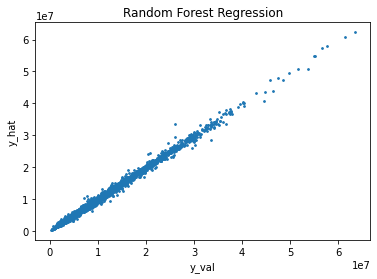

mape(%): 3.7975602429223683


In [ ]:
import matplotlib.pyplot as plt

best_predict=rf_model.predict(X_val_norm)
plt.scatter(y_val,best_predict,s=3)
plt.xlabel("y_val") 
plt.ylabel("y_hat")
plt.title("Random Forest Regression")
#plt.legend()
plt.show()

mape=np.mean(np.abs(((best_predict- (y_val))/y_val)))*100
print('mape(%):',mape)

    feature importance            features
2             0.589903         using_price
3             0.221610              CarAge
65            0.076155             type_K9
1             0.052235            TRAVDIST
36            0.023043  MJ_MODEL_KEY_adj_A
54            0.008277            SMARTKEY
4             0.004848            exchange
0             0.002939                EXHA
47            0.002401  MJ_GRADE_KEY_adj_F
5             0.001754            yongjeob
64            0.001644             type_K7
51            0.001615                 AB2
44            0.001066  MJ_GRADE_KEY_adj_C
56            0.001000       SUNLOOPCOMMON
50            0.000916                 ABS
37            0.000843  MJ_MODEL_KEY_adj_B
66            0.000724             type_레이
43            0.000574  MJ_GRADE_KEY_adj_B
63            0.000534             type_K5
15            0.000490             COLOR_A


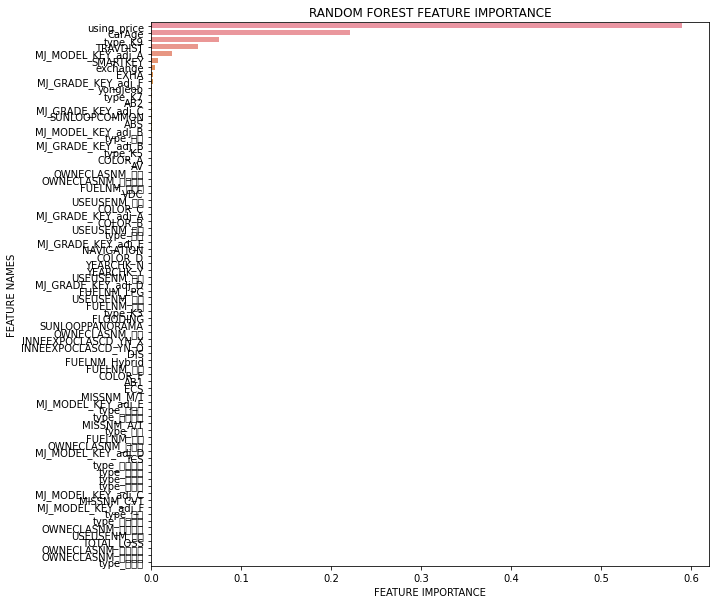

In [ ]:
import seaborn as sns

def plot_feature_importance(importance_, features_,model_type):
      dict_ = {'feature importance' : importance_, 'features' : features_}
      df = pd.DataFrame(dict_)
      df.sort_values(by=['feature importance'], ascending=False,inplace=True)
      plt.figure(figsize=(10,10))
      print(df.head(20)) # 임의로 추가
      sns.barplot(x=df['feature importance'], y=df['features'])
      plt.title(model_type + 'FEATURE IMPORTANCE')
      plt.xlabel('FEATURE IMPORTANCE')
      plt.ylabel('FEATURE NAMES')

      

plot_feature_importance(rf_model.feature_importances_ ,X_val_norm.columns, 'RANDOM FOREST ')

## P1-3. System Implementation
- df_test에 기반하여 실제 사용을 위한 system implemetation 작업 진행

In [ ]:
#test셋에 데에서 성능 확인
test_data=pd.read_csv("/content/drive/Shareddrives/데이터애널리틱스_송재욱교수님_3팀/211012_6주차(해커톤)/P1_testset_sample.csv",encoding='cp949')

In [ ]:
#test셋도 모델의 input에 맞게끔 전처리
TypeList = ['K3', 'K5', 'K7', 'K9', '레이', '로체', '리오', '모닝', '비스토', '스팅어', '스펙트라', '쎄라토', '오피러스', '옵티마', '포르테', '프라이드']
Type_name_list=[] #점차 append됨

for Type in TypeList:
  type_name = 'type_' + Type
  Type_name_list.append(type_name)
  test_data[type_name] = test_data.iloc[:,2].str.contains(Type).astype(int)

#모닝 레이디라 레이도 포함한거라 type_레이는 0으로 포함
test_data['type_레이'][(test_data['type_레이']==1)&(test_data['type_모닝']==1)]=0



#나머지 12개 데이터 제거
# test_data['type_나머지']= 0
# (test_data['type_나머지'][ test_data[Type_name_list].sum(axis=1)==0])=1  #나머지에 해당하는 것들 하나의 그룹으로 . 12개나옴

limitprice_per_type={
    'type_K3' :[13700000, 24250000], #K3
'type_K5':[14200000 ,38850000], #K5, K5하이브리드
'type_K7' :[26100000,40320000], #K7, K7하이브리드
'type_K9' :[50900000,92070000], #K9
'type_레이': [11350000,45000000], #레이 ,레이EV 전기차 특수로 4500까지
'type_로체':[15000000,28800000], # 로체
'type_리오':[6000000,19800000], #리오해치백, 리오세단, 리오SF해치백, 리오SR세단
'type_모닝':[6500000,15000000], #모닝
'type_비스토':[5200000,8000000], #비스토
'type_스팅어':[35000000,53000000], # 스팅어
'type_스펙트라':[8500000,14530000],#윙이랑 그냥
'type_쎄라토':[9000000,17290000],#해치백이랑그냥
'type_오피러스':[27700000,55800000],
'type_옵티마':[11990000,24840000], #리갈이랑 그냥
'type_포르테':[13390000,19660000], #해치백 ,쿱
'type_프라이드':[11090000,17480000] #세단이랑 그냥

}

def apply_limit_price(row):#row 데이터에 적용하는 함수

    for type_ in  Type_name_list:
        if row[Type_name_list][type_] ==1:
            this_type=type_
            break #타입 찾으면 탈출
    #print(type_)
    under=limitprice_per_type[type_][0]
    #print(under)
    upper=limitprice_per_type[type_][1]
    #print(upper)

    for price in  ['SHIPPING_PRICE','NC_GRADE_PRICE','NEWCARPRIC']:
        
        if row[price]==np.NaN:
            continue

        elif row[price]<under:
            continue
        
        elif row[price]>upper:
            continue
        
        else:
            return row[price]
            
    
    return np.NaN #3개 모두 bound값 벗어날때

test_data['using_price']=test_data.apply(apply_limit_price,axis=1)

#bound안에 들어가는지 확인코드 (k7의경우 4030만 이하)
test_data['using_price'][test_data['type_K7']==1].max()

#차 몇년됐는지
test_data['SUCCYMD']=pd.to_datetime(test_data['SUCCYMD'],format='%Y%m%d')
test_data['CARREGIYMD']=pd.to_datetime(test_data['CARREGIYMD'],format='%Y%m%d')
test_data['CarAge']=(test_data['SUCCYMD']-test_data['CARREGIYMD']).astype(int)  #초단위가 값이 큰데 나중에 정규화됨

#binary합
description=pd.read_excel("/content/drive/Shareddrives/데이터애널리틱스_송재욱교수님_3팀/211012_6주차(해커톤)/P1_Data_Description.xlsx")
exchange=description['컬럼 ID'][17:62]#bonet~side_member_frame2
yongjeob=description['컬럼 ID'][62:77]#LEFT_INSIDE_SHEETING~RIGHT_SIDE_PANEL_SHEETING


test_data['exchange']=test_data[exchange].sum(axis=1) #교환관련 binary합
test_data['yongjeob']=test_data[yongjeob].sum(axis=1) #판금+용접 관련 binary합

used_binary_col=pd.concat([exchange,yongjeob],ignore_index=True).to_list() #나중에 사용한 변수 제거용

def sortedplot(df):
    sorted_df=df.sort_values().reset_index(drop=True)
    sorted_df.plot()

#
mj_model_key=test_data['MJ_MODEL_KEY'].sort_values().reset_index(drop=True)
#그룹별 모델적용
#


#40까지 하나,46까지하나,55까지하나,64까지 하나, 73까지 하나 , 그리고 1160 따로

def num_to_cat_MJMODELKEY(data):
    if data<=40:
        return 'A'
    elif data<=46:
        return 'B'
    elif data<=55:
        return 'C'
    
    elif data<=64:
        return 'D'
    elif data<=300:
        return 'E'
    else:                #1160을 위한 값
        return 'F'

#만든 mapping함수 적용
test_data['MJ_MODEL_KEY_adj']=test_data['MJ_MODEL_KEY'].apply(num_to_cat_MJMODELKEY)

#

#sortedplot(test_data['MJ_GRADE_KEY'])

mj_grade_key=test_data['MJ_GRADE_KEY'].sort_values().reset_index(drop=True)
#그룹별 모델적용
#


#1241까지 하나,2534까지하나,5790까지하나,9161까지 하나, 10914까지 하나 , 16930이상

def num_to_cat_MJGRADEKEY(data):
    if data<=1241:
        return 'A'
    elif data<=2534:
        return 'B'
    elif data<=5790:
        return 'C'
    elif data<=9161:
        return 'D'
    elif data<=10914:
        return 'E'
    else:                #16930이상
        return 'F'

test_data['MJ_GRADE_KEY_adj']=test_data['MJ_GRADE_KEY'].apply(num_to_cat_MJGRADEKEY)
test_data['MJ_GRADE_KEY_adj'].value_counts()

#

#모두다 같은 값 가지는 열
notuselist=[]
for column in test_data.columns:
  if column == 'SUCCYMD': ########################################################테스트 데이터의 경우 낙찰일자가 다 같은 데이터임. 
      continue

  if sum(test_data[column] == test_data[column].unique()[0]) == len(test_data):
      notuselist.append(column)

used_binary_col=[x for x in used_binary_col if x not in notuselist] #없어진 것 적용

#데이터빼기
test_data=test_data.drop(notuselist,axis=1) #모두다 같은 값 가지는 열 빼주는

test_data=test_data.drop(used_binary_col+['CARNM','SHIPPING_PRICE' , 'NC_GRADE_PRICE' , 'NEWCARPRIC','SUCCYMD','CARREGIYMD','MJ_MODEL_KEY','MJ_GRADE_KEY','DT_MODEL_KEY','DT_GRADE_KEY','NC_GRADE_KEY'],axis=1) #파생변수 만드는데 사용해서 빼주는
test_data=test_data.drop(['YEAR','GOODNO','CHASNO'],axis=1) #그냥 느낌으로 빼주는

#남은 null값 확인
test_data.isnull().sum()

#대부분의 결측치가 using_price인데 우리의 만든 기준을 벗어나는 값이므로 전부 제거,  'USEUSENM'도 300개정도의 결측치 ->중요도 낮으므로 제거
test_data=test_data.dropna()
test_data.isnull().sum().sum()

test_data.dtypes

cat_columns=[i for i,j in zip(test_data.columns,test_data.dtypes) if j=='object']
num_columns=['EXHA','TRAVDIST','using_price','CarAge','exchange','yongjeob','SUCCPRIC']#예측해야할 y값
already_oh_columns=[i for i in test_data.columns if i not in cat_columns+num_columns]#binary데이터 

test_data[cat_columns]

#원핫인코딩후 최종데이터를 using_data라는 객체로 반환(일단 예측y값 포함한상태)
using_catdata=test_data[cat_columns]
using_numdata=test_data[num_columns]
using_alohdata=test_data[already_oh_columns]

doing_onehot=pd.get_dummies(using_catdata)

#cat데이터에 원핫 진행후 합쳐줌
using_data=pd.concat([using_numdata,doing_onehot],axis=1)
using_data=pd.concat([using_data,using_alohdata],axis=1)

#null값 없음을 확인
using_data.isnull().sum().sum()

#랜덤포레스트 적용


def z_normalize (train, list): # 대상이 될 dataset과 feature list를 받으면 normalization 해주는 함수. 이때 사용된 평균과 표준편차를 함께 return한다.
  data=train.loc[:, list]
  mean=data.mean()  # mean값 저장
  std=data.std()    # standard deviation 저장
  data=(data-mean)/std  # normalization
  return data, [mean,std]

def z_normalize_val (val, list, cache): # train set normalization에서 사용된 식을 그대로 적용해주는 함수. cache=[mean,std]
  data=val.loc[:, list]
  mean=cache[0]
  std=cache[1]
  data=(data-mean)/std
  return data

def splitData(df, ratio, y_column):
    
    columns_ = df.columns
    # Subsample the data
    mask = list(range(0,df.shape[0], ratio))
    X_val = df.iloc[mask, :].drop(y_column, 1)
    y_val = df.iloc[mask][y_column]
    
    mask = ~df.index.isin(mask)
    X_train = df.loc[mask, :].drop(y_column, 1)
    y_train = df.loc[mask, y_column]
    
    return X_train, y_train, X_val, y_val

# train set, validation set split 
# train set, validation set = 4 : 1

#X_train, y_train, X_val, y_val = splitData(using_data, 5, y_column = 'SUCCPRIC') 



y_test=using_data['SUCCPRIC']
test_data_x=using_data.drop(['SUCCPRIC'],axis=1)









#y값 뺀 num데이터에 대해 normalize진행
tmp_num_columns=num_columns.copy()
tmp_num_columns.remove('SUCCPRIC')


test_data_x_norm = test_data_x.copy()
test_data_x_norm.loc[:, tmp_num_columns], cache = z_normalize(test_data_x, tmp_num_columns)
#X_val_norm = X_val.copy()
#X_val_norm.loc[:, tmp_num_columns] = z_normalize_val(X_val, tmp_num_columns, cache)

#X_train.isnull().sum()

#X_train_norm.isnull().sum().sum()

#from sklearn.ensemble import RandomForestRegressor
#rf_model = RandomForestRegressor()
#rf_model.fit(X_train_norm,y_train)







In [ ]:
#테스트 해볼 데이터객체:test_data_x_norm

#test셋에서 모자란 원핫인코딩된 칼럼 추가
have_to_add_cols= X_train.columns[(X_train.columns.isin(test_data_x_norm.columns) ) ==False].to_list()

if len(have_to_add_cols) is not 0:
    test_data_x_norm[have_to_add_cols]=np.zeros((test_data_x_norm.shape[0],len(have_to_add_cols)))

#기존 training data 순서에 맞도록 test데이터의 열 순서 조절
test_data_x_norm=test_data_x_norm[X_train.columns]

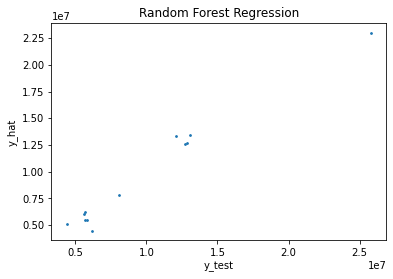

mape(%): 7.489387638584821


In [ ]:
import matplotlib.pyplot as plt

best_predict=rf_model.predict(test_data_x_norm) #rf_model은 위의 training set에서 학습된 모델
plt.scatter(y_test,best_predict,s=3)
plt.xlabel("y_test") 
plt.ylabel("y_hat")
plt.title("Random Forest Regression")
#plt.legend()
plt.show()

mape=np.mean(np.abs(((best_predict- (y_test))/y_val)))*100
print('mape(%):',mape)